In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting
from lib.tile_coding import IHT, tiles
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
env = gym.make("MountainCar-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, alpha, num_tilings=8, max_size=4096):
        self.max_size = max_size
        self.num_tilings = num_tilings

        # divide step size equally to each tiling
        self.alpha = alpha / num_tilings

        self.iht = IHT(max_size)

        # weight for each tile
        self.weights = np.zeros(max_size)

        # position and velocity needs scaling to satisfy the tile software
        self.position_scale = self.num_tilings / (env.observation_space.high[0] - env.observation_space.low[0])
        self.velocity_scale = self.num_tilings / (env.observation_space.high[1] - env.observation_space.low[1])
       
    def featurize_state_action(self, state, action):
        """
        Returns the featurized representation for a state.
        """
        featurized = tiles(self.iht, self.num_tilings, [self.position_scale * state[0], self.velocity_scale * state[1]], [action])
        return featurized
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
    
        if a is None:
            features = [self.featurize_state_action(s, i) for i in range(env.action_space.n)]
        else:
            features = [self.featurize_state_action(s, a)]
            
        return [np.sum(self.weights[f]) for f in features]
        
    
    def update(self, s, a, target):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        features = self.featurize_state_action(s, a)
        estimation = np.sum(self.weights[features])
        delta = self.alpha * (target - estimation)
        for f in features:
            self.weights[f] += delta
        

In [4]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [5]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # Only used for SARSA, not Q-Learning
        next_action = None
        
        # One step in the environment
        for t in itertools.count():
                        
            # Choose an action to take
            # If we're using SARSA we already decided in the previous step
            if next_action is None:
                action_probs = policy(state)
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            else:
                action = next_action
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            q_values_next = estimator.predict(next_state)
            
            # Use this code for Q-Learning
            # Q-Value TD Target
            # td_target = reward + discount_factor * np.max(q_values_next)
            
            # Use this code for SARSA TD Target for on policy-training:
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)             
            td_target = reward + discount_factor * q_values_next[next_action]
            
            # Update the function approximator using our target
            estimator.update(state, action, td_target)
            
            print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward), end="")
                
            if done:
                break
                
            state = next_state
    
    return stats

In [6]:
estimator = Estimator(alpha=0.5)

In [7]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats = q_learning(env, estimator, 500, epsilon=0)

Step 145 @ Episode 500/500 (-106.0)

/Users/michaeloneill/Documents/RL/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


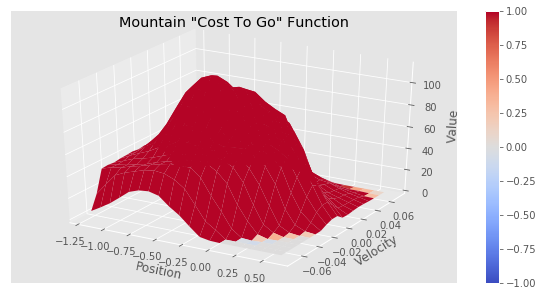

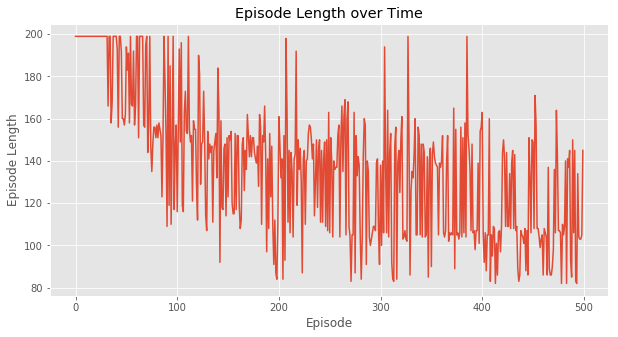

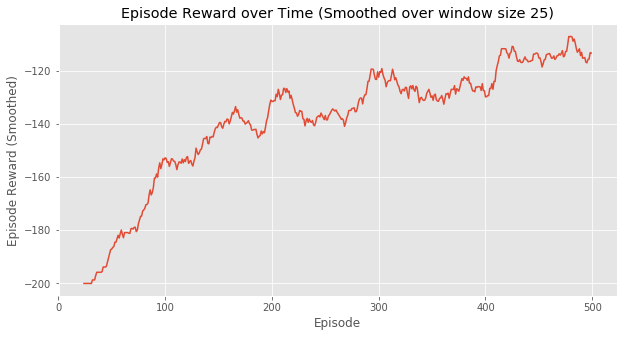

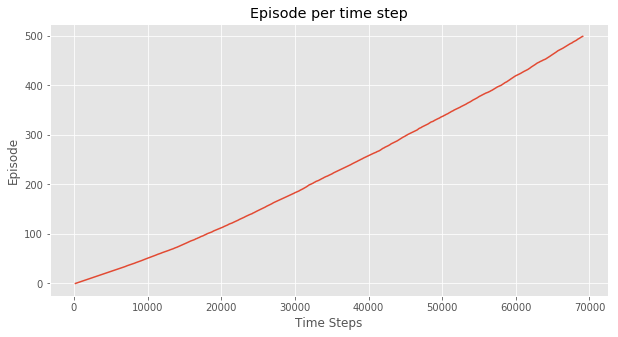

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [8]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)

## Plot learned policy

In [9]:
import time
env = gym.make("MountainCar-v0")
epsilon = 0
# The policy we're following
policy = make_epsilon_greedy_policy(
        estimator, epsilon, env.action_space.n)
#for i_episide in range(20):
state = env.reset()
for t in itertools.count():
    #env.render()
    time.sleep(0.01)
    action_probs = policy(state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
    state, _, done, _ = env.step(action)
    env.render()
    if done:
        break

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
